## <span style="color:White; font-size:24px; font-weight:bold;">About Project</span>

This project uses datasets from a Brazilian e-commerce company called Olist, containing information on approximately 100,000 orders placed between 2016 and 2018 across multiple online marketplaces in Brazil. The dataset provides the ability to view each order from multiple dimensions; however, this analysis focuses on selected features for an exploratory data analysis (EDA). Using Matplotlib and Seaborn, I visualize key metrics to better understand the platform’s evolution and extract actionable business insights.

Subsequently, I built a sales forecasting model, specifically predicting sales in the first 30 days after a new product launch. This scenario is designed to simulate a real-world business case, and leveraging historical data on existing products — including sales performance and product attributes — to build a regression model that forecasts the expected revenue of new products. Such predictions can help e-commerce platforms and sellers make more informed business decisions when launching new products.




## <span style="color:White; font-size:24px; font-weight:bold;">Table of Content</span>

1. Getting Started
2. Loading Data
3. Exploratory Data Analysis
   - 3.1 An Overview of Olist’s E-commerce Evolution
   - 3.2 Top Products Categories by Sales and Orders
   - 3.3 Customers Geographic Distribution and purchase pattern 
4. Modeling
    - 4.1 Preprocessing
    - 4.2 Build Linear Regression Model
    - 4.3 Build Random Forest Model
5.  Summary
      

## <span style="color:White; font-size:24px; font-weight:bold;">1. Getting Started</span>


In [1]:
#Libraries
import pandas as pd
pd.set_option('display.max_colwidth',80)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mtick 
import folium
from folium.plugins import HeatMap
from IPython.display import display

#Modeling
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split,cross_val_score, KFold, cross_validate
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,make_scorer
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
#Reading the Data
customer_data = pd.read_csv('/kaggle/input/e-commerce-data/E-commerce Data/olist_customers_dataset.csv')
order_items_data = pd.read_csv('/kaggle/input/e-commerce-data/E-commerce Data/olist_order_items_dataset.csv')
order_payment_data= pd.read_csv('/kaggle/input/e-commerce-data/E-commerce Data/olist_order_payments_dataset.csv')
orders_data = pd.read_csv('/kaggle/input/e-commerce-data/E-commerce Data/olist_orders_dataset.csv')
product_data = pd.read_csv('/kaggle/input/e-commerce-data/E-commerce Data/olist_products_dataset.csv')
product_translation = pd.read_csv('/kaggle/input/e-commerce-data/E-commerce Data/product_category_name_translation.csv')
geo = pd.read_csv('/kaggle/input/e-commerce-data/E-commerce Data/olist_geolocation_dataset.csv')

## <span style="color:White; font-size:24px; font-weight:bold;">2. Data Structure Overview</span>

As a first step, I consolidated the information from the different datasets into a single, integrated table to facilitate easier access and analysis in the subsequent steps.

In [3]:
datasets = [customer_data, order_items_data, order_payment_data, orders_data, product_data]
names = ['customer_data', 'order_items_data', 'order_payment_data', 'orders_data', 'product_data']

# Basic information
data_info = pd.DataFrame({})
data_info['datasets'] = names

data_info['nrows'] = [df.shape[0] for df in datasets]
data_info['ncols'] = [df.shape[1] for df in datasets]
data_info['null_cnt'] = [df.isnull().sum().sum() for df in datasets]
data_info['null_cols_cnt'] = [len([col for col, num in df.isnull().sum().items() if num>0]) for df in datasets]
data_info['null_cols_name'] = [','.join([col for col,num in df.isnull().sum().items() if num>0]) for df in datasets]
data_info = data_info.style.background_gradient(cmap='Oranges')

display(data_info)

# Datasets Overview
dataset_list = []
column_list = []
type_list = []
null_list = []

for name, df in zip(names, datasets):
    dataset_list += [name] * len(df.columns)
    column_list += list(df.columns)
    type_list += list(df.dtypes)
    null_list += list(df.isnull().sum())

df_overview = pd.DataFrame({
    'dataset': dataset_list,
    'column_name': column_list,
    'data_type' : type_list,
    'null_cnt': null_list
})


display(df_overview)

dataset                    column_name data_type  null_cnt
0        customer_data                    customer_id    object         0
1        customer_data             customer_unique_id    object         0
2        customer_data       customer_zip_code_prefix     int64         0
3        customer_data                  customer_city    object         0
4        customer_data                 customer_state    object         0
5     order_items_data                       order_id    object         0
6     order_items_data                  order_item_id     int64         0
7     order_items_data                     product_id    object         0
8     order_items_data                      seller_id    object         0
9     order_items_data            shipping_limit_date    object         0
10    order_items_data                          price   float64         0
11    order_items_data                  freight_value   float64         0
12  order_payment_data                       order_id    object         0
13  order_payment_data             payment_sequential     int64         0
14  order_payment_data                   payment_type    object         0
15  order_payment_data           payment_installments     int64         0
16  order_payment_data                  payment_value   float64         0
17         orders_data                       order_id    object         0
18         orders_data                    customer_id    object         0
19         orders_data                   order_status    object         0
20         orders_data       order_purchase_timestamp    object         0
21         orders_data              order_approved_at    object       160
22         orders_data   order_delivered_carrier_date    object      1783
23         orders_data  order_delivered_customer_date    object      2965
24         orders_data  order_estimated_delivery_date    object         0
25        product_data                     product_id    object         0
26        product_data          product_category_name    object       610
27        product_data            product_name_lenght   float64       610
28        product_data     product_description_lenght   float64       610
29        product_data             product_photos_qty   float64       610
30        product_data               product_weight_g   float64         2
31        product_data              product_length_cm   float64         2
32        product_data              product_height_cm   float64         2
33        product_data               product_width_cm   float64         2

## <span style="color:White; font-size:24px; font-weight:bold;">3. Exploratory Data Analysis</span>

In the next section, I focus on three key aspects of interest for exploration:

 - An overview of Olist’s e-commerce business growth trends from 2016 to 2018

 - Top product categories by sales and order volume

 - Customer geographic distribution and purchase patterns

### 3.1 An Overview of Olist’s E-commerce Evolution

In [4]:
#merge order dataset with payment dataset
df_orders = orders_data.merge(order_payment_data, how = 'left', on= 'order_id')
df_orders = df_orders[['order_id','order_purchase_timestamp','payment_value']]

#extract time info
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])
df_orders['purchase_year'] = df_orders['order_purchase_timestamp'].apply(lambda x:x.year)
df_orders['purchase_year_month'] = df_orders['order_purchase_timestamp'].apply(lambda x:x.strftime('%Y%m'))
df_orders['purchase_dayofweek'] = df_orders['order_purchase_timestamp'].apply(lambda x:x.strftime('%a'))
df_orders['purchase_hour'] = df_orders['order_purchase_timestamp'].apply(lambda x:x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['purchase_time_day'] = pd.cut(df_orders['purchase_hour'], hours_bins, labels=hours_labels)

df_orders.head()


order_id order_purchase_timestamp  payment_value  \
0  e481f51cbdc54678b7cc49136f2d6af7      2017-10-02 10:56:33          18.12   
1  e481f51cbdc54678b7cc49136f2d6af7      2017-10-02 10:56:33           2.00   
2  e481f51cbdc54678b7cc49136f2d6af7      2017-10-02 10:56:33          18.59   
3  53cdb2fc8bc7dce0b6741e2150273451      2018-07-24 20:41:37         141.46   
4  47770eb9100c2d0c44946d9cf07ec65d      2018-08-08 08:38:49         179.12   

   purchase_year purchase_year_month purchase_dayofweek  purchase_hour  \
0           2017              201710                Mon             10   
1           2017              201710                Mon             10   
2           2017              201710                Mon             10   
3           2018              201807                Tue             20   
4           2018              201808                Wed              8   

  purchase_time_day  
0           Morning  
1           Morning  
2           Morning  
3             Night  
4           Morning

In [5]:
#payment aggregate by yearmonth
df_orders_agg = df_orders.groupby(by='purchase_year_month')['payment_value'].sum().reset_index().sort_values('purchase_year_month')
df_orders_agg.head()

#calculate growth rate 2017 vs 2018
month_range = ['201701', '201702', '201703', '201704', '201705', '201706', '201707', '201708',
               '201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808']
filtered_df = df_orders[df_orders['purchase_year_month'].isin(month_range)]
temp1 = filtered_df.groupby(by='purchase_year')['payment_value'].sum().reset_index().sort_values('purchase_year')
temp2 = filtered_df.groupby(by='purchase_year').size().reset_index(name='count').sort_values('purchase_year')
temp1['pct_change'] = temp1['payment_value'].pct_change()*100
temp2['pct_change'] = temp2['count'].pct_change()*100
payment_growth = round(temp1.iloc[1,2],1)
order_growth = round(temp2.iloc[1,2],1)

payment_2017 = round((temp1.iloc[0,1] / 1000000),2)
payment_2018 = round((temp1.iloc[1,1] / 1000000),2)

order_2017 = temp2.iloc[0,1]
order_2018 = temp2.iloc[1,1]
order_2017_str = f"{order_2017:,.0f}"
order_2018_str = f"{order_2018:,.0f}"


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_36/3714382951.py:61: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


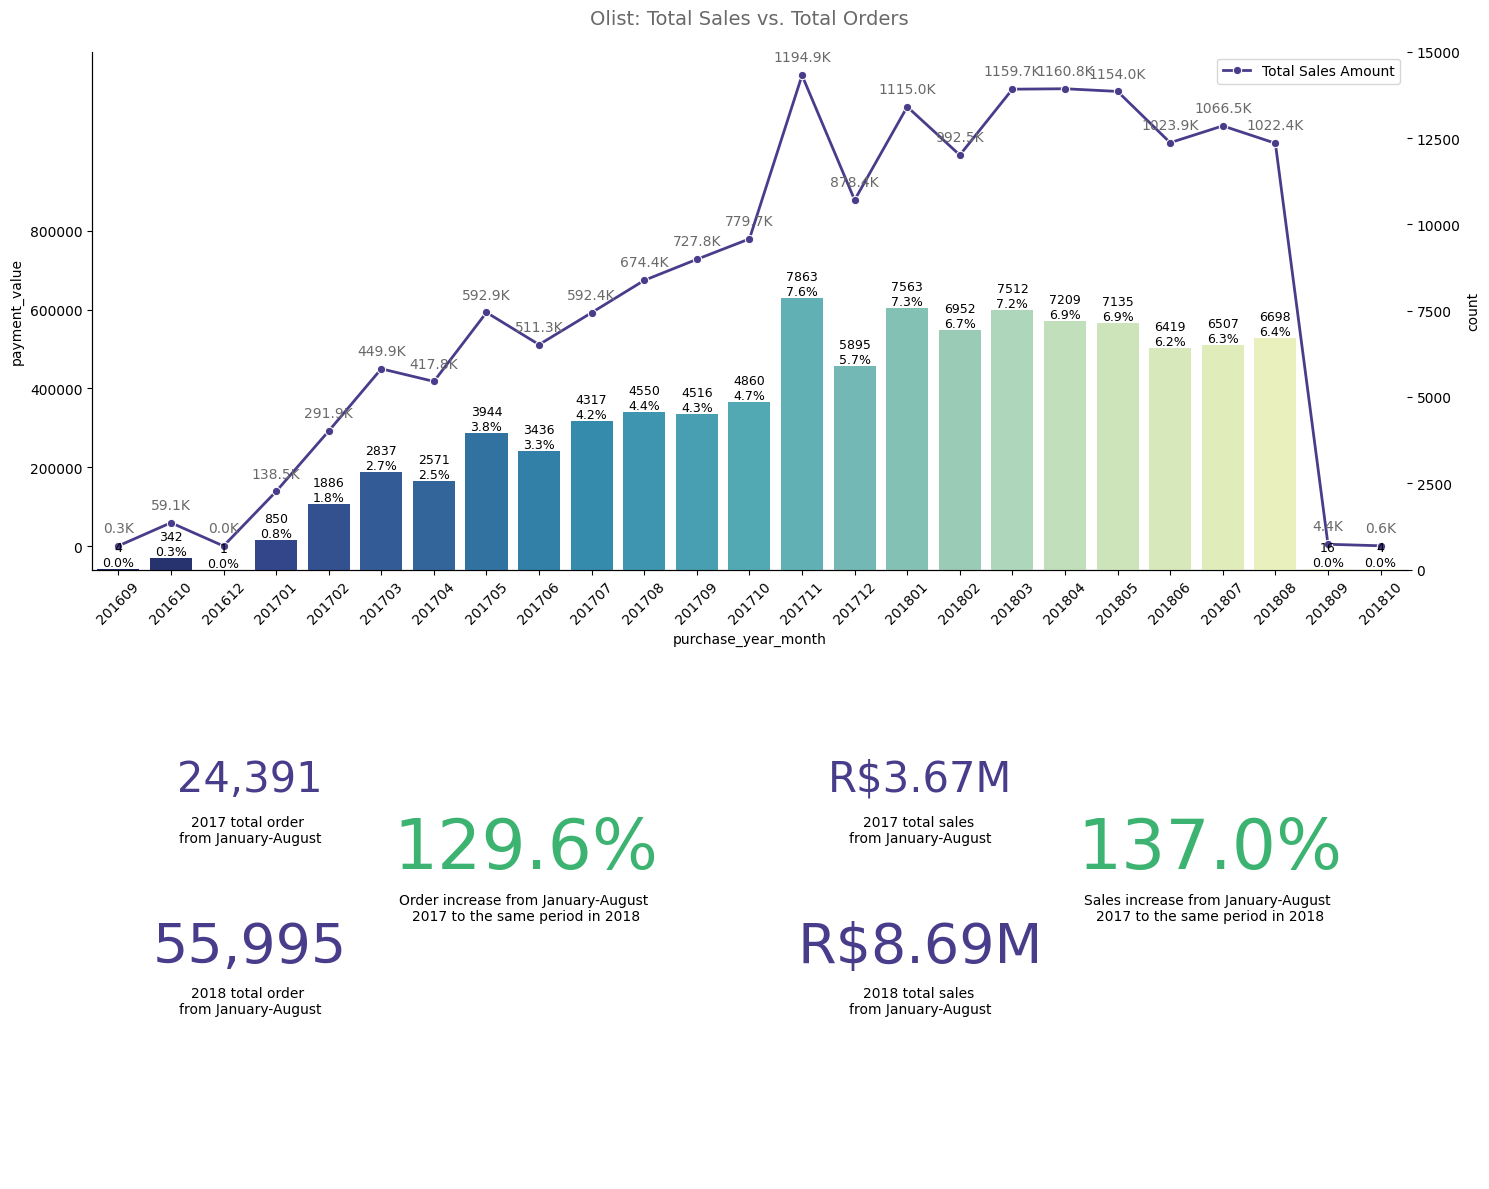

In [6]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])
#ax3 = fig.add_subplot(gs[1, 1:])

#Spine definition
def format_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

# Plot 1 - Evolution of total orders and total sales on e-commerce
sns.lineplot(x='purchase_year_month', y='payment_value', ax=ax1, data=df_orders_agg, linewidth=2, 
             color='darkslateblue', marker='o', label='Total Sales Amount')
ax1_twx = ax1.twinx()
order = df_orders_agg['purchase_year_month'].tolist()
sns.countplot(x='purchase_year_month', ax = ax1_twx, data = df_orders, order = order ,palette='YlGnBu_r')
ax1_twx.set_yticks(np.arange(0, 17000, 2500))
ax1.set_yticks(np.arange(0, 1000000, 200000))

# Customizing the first plot
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
for x, y in df_orders_agg.payment_value.items():
    ax1.annotate(str(round(y/1000, 1))+'K', xy=(x, y), textcoords='offset points', xytext=(0, 10),
                ha='center', color='dimgrey')
ax1.set_title('Olist: Total Sales vs. Total Orders', size=14, color='dimgrey', pad=20)

total = len(df_orders)
for p in ax1_twx.patches:
    count = int(p.get_height())
    percent = f'{count / total:.1%}'
    ax1_twx.annotate(f'{count}\n{percent}', (p.get_x() + p.get_width() / 2, p.get_height()), 
                 ha='center', va='bottom',fontsize=9)
format_spines(ax1)
format_spines(ax1_twx) 

ax2.text(0.33, 0.6,str(order_growth) + '%' , fontsize=50, color='mediumseagreen', ha='center')
ax2.text(0.33, 0.5, 'Order increase from January-August \n2017 to the same period in 2018', fontsize=10, ha='center')

ax2.text(0.12, 0.75,order_2017_str, fontsize=30, color='darkslateblue', ha='center')
ax2.text(0.12, 0.65, '2017 total order \nfrom January-August', fontsize=10, ha='center')
ax2.text(0.12, 0.42,order_2018_str, fontsize=40, color='darkslateblue', ha='center')
ax2.text(0.12, 0.32, '2018 total order \nfrom January-August', fontsize=10, ha='center')


ax2.text(0.85, 0.6, str(payment_growth) + '%', fontsize=50, color='mediumseagreen', ha='center')
ax2.text(0.85, 0.5, 'Sales increase from January-August \n2017 to the same period in 2018', fontsize=10, ha='center')

ax2.text(0.63, 0.75,'R$'+str(payment_2017)+'M', fontsize=30, color='darkslateblue', ha='center')
ax2.text(0.63, 0.65, '2017 total sales \nfrom January-August', fontsize=10, ha='center')
ax2.text(0.63, 0.42,'R$'+str(payment_2018)+'M', fontsize=40, color='darkslateblue', ha='center')
ax2.text(0.63, 0.32, '2018 total sales \nfrom January-August', fontsize=10, ha='center')
ax2.axis('off')

plt.tight_layout()
plt.show()

According to the plot above，the Olist’s e-commerce business has achieved exponential growth in both order volume and sales revenue. The strong growth in both orders and sales suggests increased customer demand and/or expanded market reach in 2018. The sales growth rate slightly outpaced order growth, indicating a possible increase in Average Order Value (AOV).November appears to be a seasonal peak month, likely influenced by holiday shopping or promotional events.

### 3.2  Top Products Categories by Sales and Orders

In [7]:
df1 = order_items_data.drop_duplicates(subset='order_id')
df1 = df1.merge(product_data,on='product_id',how='left')
df1 = df_orders.merge(df1,on='order_id',how='inner')[['order_id','product_id','product_category_name','payment_value']]
df1 = df1.merge(product_translation, on='product_category_name',how='left')[['order_id','product_id','product_category_name_english','payment_value']]

df1_grouped = df1.groupby('product_category_name_english').agg({"payment_value":"sum", "order_id":"nunique"}).sort_values(by=['payment_value','order_id'],ascending=False)[0:10].reset_index()
df1_grouped.columns = ['product_category_name','payment_value','order_amount']
df1_grouped

product_category_name  payment_value  order_amount
0          health_beauty     1439926.41          8796
1          watches_gifts     1303159.52          5601
2         bed_bath_table     1240930.24          9311
3         sports_leisure     1157754.33          7681
4  computers_accessories     1057630.10          6660
5        furniture_decor      906602.02          6355
6             housewares      780774.19          5829
7             cool_stuff      720651.86          3603
8                   auto      685302.45          3880
9           garden_tools      584380.24          3482

/tmp/ipykernel_36/1397047398.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


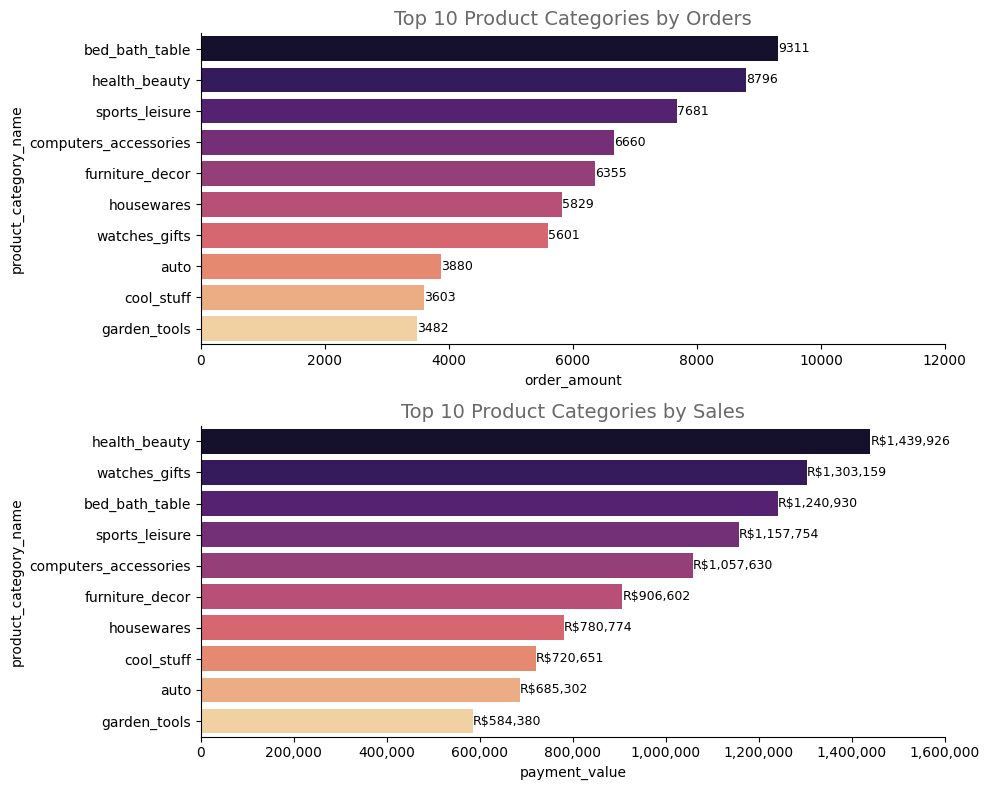

In [8]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(10, 8))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

# first plot : category ranking by orders
sns.barplot(
    data=df1_grouped,
    x='order_amount', y='product_category_name',
    ax=ax1,
    order=df1_grouped.sort_values(by='order_amount', ascending=False)['product_category_name'],
    palette='magma', linewidth=1
)
ax1.set_xticks(np.arange(0, 13000, 2000))
ax1.set_title('Top 10 Product Categories by Orders', size=14, color='dimgrey')

for p in ax1.patches:
    count = int(p.get_width())
    ax1.annotate(count, 
                 (p.get_width(), p.get_y() + p.get_height() / 2),
                 ha='left', va='center', fontsize=9)

format_spines(ax1)

# second plot : category ranking by sales
sns.barplot(
    data=df1_grouped,
    x='payment_value', y='product_category_name',
    ax=ax2,
    order=df1_grouped['product_category_name'].tolist(),
    palette='magma', linewidth=1
)

ax2.set_xticks(np.arange(0, 1800000, 200000))
ax2.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))  # 添加千分位

ax2.set_title('Top 10 Product Categories by Sales', size=14, color='dimgrey')

for p in ax2.patches:
    value = int(p.get_width())
    ax2.annotate(f'R${value:,}', 
                 (p.get_width(), p.get_y() + p.get_height() / 2),
                 ha='left', va='center', fontsize=9)


format_spines(ax2)
plt.tight_layout()
plt.show()


From this chart, we can conclude:

1. Order Volume

 - bed_bath_table has the highest order volume, followed by health_beauty and sports_leisure.

 - There is a significant gap in order volumes among the top 10 categories, with the top three categories showing notably higher volumes compared to the rest (e.g., garden_tools has only 3,482 orders).

2. Sales Revenue

- The highest sales revenue comes from health_beauty, followed by watches_gifts and bed_bath_table.

- Although bed_bath_table ranks first in order volume, it is third in sales revenue, indicating a relatively low Average Order Value (AOV).

- Conversely, watches_gifts ranks seventh in order volume but second in sales revenue, suggesting a high AOV.

3. Average Order Value Differences

- Categories such as watches_gifts and auto have higher sales revenue rankings than order volume rankings, implying higher transaction values per order. These categories could be prioritized for premium market strategies.

- Categories such as bed_bath_table and sports_leisure have relatively low AOV and rely on high sales volumes. Strategies such as product bundling or upselling could be considered to increase the AOV.

### 3.3 Customers Geographic Distribution and purchase pattern 

In [9]:
# customer geo location 
# clean geo data
geo_clean = geo.groupby('geolocation_zip_code_prefix')[['geolocation_lat', 'geolocation_lng']].mean().reset_index()
# merge customer data
customers_geo = customer_data.merge(geo_clean,left_on='customer_zip_code_prefix',right_on='geolocation_zip_code_prefix',how='left')
# heatmap data prepare
heat_data = customers_geo[['geolocation_lat', 'geolocation_lng']].dropna().values.tolist()

# create heatmap
m = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)
HeatMap(heat_data, radius=11, blur=15).add_to(m)

display(m)


This heatmap visualizes the geographic distribution of Olist’s customers across Brazil. The customer base is heavily concentrated in Brazil’s urban and coastal regions, with the highest density in São Paulo and significant clusters in Rio de Janeiro, Belo Horizonte, and major northeastern cities, while inland and northern areas show much lower engagement. Expansion opportunities may exist in lower-density inland regions, but infrastructure and logistics would be key considerations.

In [10]:
df2 = df_orders.drop_duplicates('order_id')
df2.head()

order_id order_purchase_timestamp  payment_value  \
0  e481f51cbdc54678b7cc49136f2d6af7      2017-10-02 10:56:33          18.12   
3  53cdb2fc8bc7dce0b6741e2150273451      2018-07-24 20:41:37         141.46   
4  47770eb9100c2d0c44946d9cf07ec65d      2018-08-08 08:38:49         179.12   
5  949d5b44dbf5de918fe9c16f97b45f8a      2017-11-18 19:28:06          72.20   
6  ad21c59c0840e6cb83a9ceb5573f8159      2018-02-13 21:18:39          28.62   

   purchase_year purchase_year_month purchase_dayofweek  purchase_hour  \
0           2017              201710                Mon             10   
3           2018              201807                Tue             20   
4           2018              201808                Wed              8   
5           2017              201711                Sat             19   
6           2018              201802                Tue             21   

  purchase_time_day  
0           Morning  
3             Night  
4           Morning  
5             Night  
6             Night

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/tmp/ipykernel_36/2173157068.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


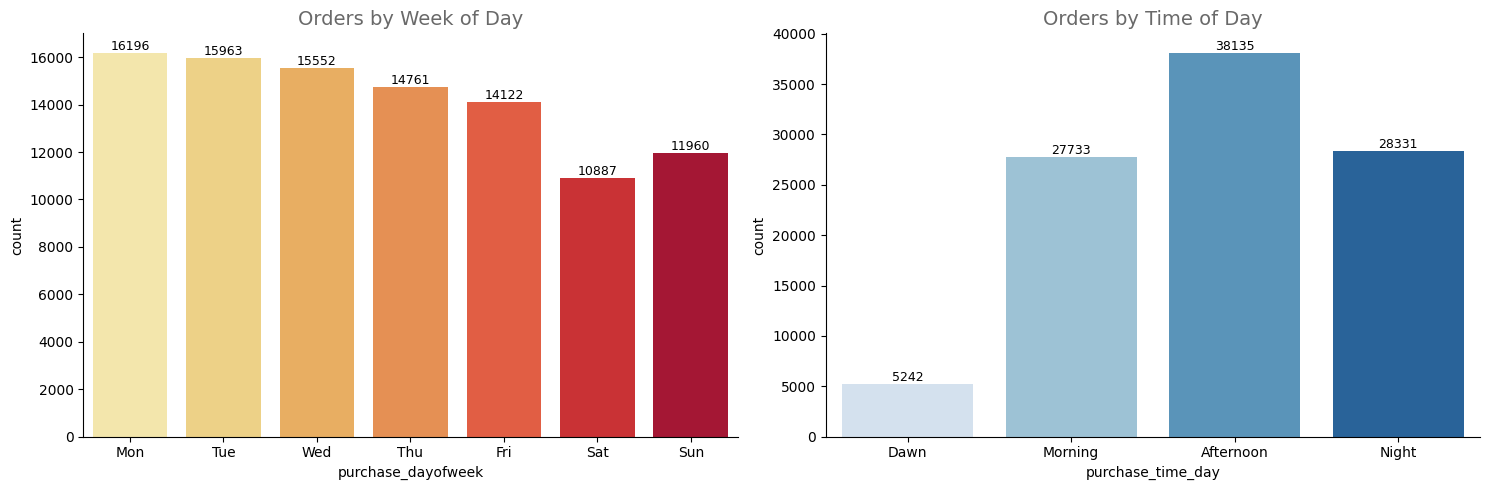

In [11]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 5))

# Axis definition
gs = GridSpec(1, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

#first plot
weekofday = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
sns.countplot(data= df2, x='purchase_dayofweek',order = weekofday,palette='YlOrRd',ax= ax1)
for p in ax1.patches:
    count = int(p.get_height())
    ax1.annotate(count, (p.get_x() + p.get_width() / 2, p.get_height()), 
                 ha='center', va='bottom',fontsize=9)
ax1.set_title('Orders by Week of Day', size=14, color='dimgrey')
format_spines(ax1)

#second plot
timeofday = ['Dawn', 'Morning', 'Afternoon', 'Night']
sns.countplot(data= df2, x='purchase_time_day',order = timeofday,palette='Blues',ax= ax2)
for p in ax2.patches:
    count = int(p.get_height())
    ax2.annotate(count, (p.get_x() + p.get_width() / 2, p.get_height()), 
                 ha='center', va='bottom',fontsize=9)
ax2.set_title('Orders by Time of Day', size=14, color='dimgrey')
format_spines(ax2)

plt.tight_layout()
plt.show()

This two charts shows customer purchase pattern: 
1. Orders by Day of the Week

- The highest order volumes occur on Monday and Tuesday, suggesting strong demand at the start of the week.

- Orders gradually decline from Wednesday to Friday, with a significant drop on Saturday.

- Sunday sees a slight recovery, but still lower than weekdays.

This suggests a weekday-focused marketing, especially early in the week, could yield higher returns. Weekend campaigns may require stronger promotions to boost engagement.

2. Orders by Time of Day

- Afternoon has the highest order count, followed by Night and Morning.

This indicates that peak sales periods are in the afternoon and evening, making these time slots optimal for promotional pushes, flash sales, or targeted ads.

## <span style="color:White; font-size:24px; font-weight:bold;">4. Modeling</span>

After the initial exploration of Olist’s e-commerce data, one natural question emerged: What will be the sales performance of a newly launched product?

This question is highly relevant in real-world business contexts, where e-commerce platforms and sellers typically consider:

 - Will the new product sell well?

 - What is the expected sales volume in the first week or month?

 - Should it be given priority exposure or promotional resources?

 - How should inventory be allocated?

Guided by these considerations, the main focus of my project is to “predict the sales of a new product within the first 30 days after its launch“.



### 4.1 Preprocessing

Due to the absence of explicit product launch dates in the dataset, I use the date of a product’s first recorded order as a proxy for its launch date, and measure sales within the subsequent 30 days to simulate post-launch performance.
在模型中，产品信息作为特征项，共有8个；产品上线后30天内的总销售作为预测值来建立模型。

In [12]:
# x variables
df_x = product_data.merge(order_items_data,on='product_id',how='inner')\
                  .merge(product_translation, on='product_category_name',how='inner').dropna().drop_duplicates('product_id')
df_x = df_x[['product_id','product_name_lenght','product_description_lenght','product_photos_qty','product_weight_g',
          'product_length_cm','product_height_cm','product_width_cm','price']]

# y variable
temp1 = order_items_data.drop_duplicates('order_id')
temp1= orders_data.merge(temp1,on='order_id',how='inner')
temp2 = order_payment_data.groupby('order_id')['payment_value'].sum()
temp2 = temp1.merge(temp2,on='order_id',how='inner')

temp2['order_purchase_timestamp'] = pd.to_datetime(temp1['order_purchase_timestamp'])
first_dates = temp2.groupby('product_id')['order_purchase_timestamp'].min().rename('first_date')
temp2 = temp2.merge(first_dates, on='product_id')
temp2_30days = temp2[temp2['order_purchase_timestamp'] <= temp2['first_date'] + pd.Timedelta(days=30)]
df_y = temp2_30days.groupby('product_id')['payment_value'].sum().reset_index()

#final data for modeling
mydata = df_x.merge(df_y,on='product_id',how='inner')
mydata = mydata.rename(columns = {'payment_value':'sales_in_30days'})

mydata.head()

product_id  product_name_lenght  \
0  1e9e8ef04dbcff4541ed26657ea517e5                 40.0   
1  3aa071139cb16b67ca9e5dea641aaa2f                 44.0   
2  96bd76ec8810374ed1b65e291975717f                 46.0   
3  cef67bcfe19066a932b7673e239eb23d                 27.0   
4  9dc1a7de274444849c219cff195d0b71                 37.0   

   product_description_lenght  product_photos_qty  product_weight_g  \
0                       287.0                 1.0             225.0   
1                       276.0                 1.0            1000.0   
2                       250.0                 1.0             154.0   
3                       261.0                 1.0             371.0   
4                       402.0                 4.0             625.0   

   product_length_cm  product_height_cm  product_width_cm   price  \
0               16.0               10.0              14.0   10.91   
1               30.0               18.0              20.0  248.00   
2               18.0                9.0              15.0   79.80   
3               26.0                4.0              26.0  112.30   
4               20.0               17.0              13.0   37.90   

   sales_in_30days  
0            18.30  
1           265.99  
2            87.62  
3           121.84  
4            46.19

In [13]:
#define X y
X = mydata.drop(["sales_in_30days",'product_id'], axis=1)
y = mydata["sales_in_30days"]

#Seperate train and test values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 4.2 Build Linear Regression Model

整理好数据后，我第一个使用的是线性回归模型。 我先使用了全部的特征，通过P值来筛选掉不重要的特征

In [14]:
# Build Linear Regression model
X_train_const = sm.add_constant(X_train)
ols = sm.OLS(y_train, X_train_const).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:        sales_in_30days   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                 1.257e+04
Date:                Mon, 11 Aug 2025   Prob (F-statistic):               0.00
Time:                        18:43:43   Log-Likelihood:            -1.5910e+05
No. Observations:               25025   AIC:                         3.182e+05
Df Residuals:                   25016   BIC:                         3.183e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

怀疑feature有多重共线性，vif检查

In [15]:
X_vif = X_train_const.drop(columns='const')  
vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_data)


                      feature       VIF
0         product_name_lenght  8.379391
1  product_description_lenght  2.586087
2          product_photos_qty  2.672120
3            product_weight_g  2.501352
4           product_length_cm  6.493354
5           product_height_cm  3.540312
6            product_width_cm  7.391369
7                       price  1.590597


通过结果做variable selection

In [16]:
#define X y
X_1 = mydata.drop(["sales_in_30days",'product_id','product_name_lenght','product_length_cm','product_width_cm'], axis=1)
y_1 = mydata["sales_in_30days"]

#Seperate train and test values
X1_train, X1_test, y1_train, y1_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

# Build Linear Regression model
X_train_const_1 = sm.add_constant(X1_train)
ols_1 = sm.OLS(y1_train, X_train_const_1).fit()
print(ols_1.summary())

#训练集表现
y1_pred_train = ols_1.predict(X_train_const_1)
print("Train R²:", r2_score(y1_train, y1_pred_train))
print("Train MAE:", mean_absolute_error(y1_train, y1_pred_train))
print("Train RMSE:", np.sqrt(mean_squared_error(y1_train, y1_pred_train)))

                            OLS Regression Results                            
Dep. Variable:        sales_in_30days   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                 2.012e+04
Date:                Mon, 11 Aug 2025   Prob (F-statistic):               0.00
Time:                        18:43:43   Log-Likelihood:            -1.5910e+05
No. Observations:               25025   AIC:                         3.182e+05
Df Residuals:                   25019   BIC:                         3.183e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [17]:
# 测试集表现
X1_test_const = sm.add_constant(X1_test, has_constant='add')
y1_pred_test = ols_1.predict(X1_test_const)

print("Test  R²:", r2_score(y1_test, y1_pred_test))
print("Test  MAE:", mean_absolute_error(y1_test, y1_pred_test))
print("Test  RMSE:", np.sqrt(mean_squared_error(y1_test, y1_pred_test)))

Test  R²: 0.6609450323315118
Test  MAE: 58.74836671615392
Test  RMSE: 201.84487130759513


In [18]:
# cross validation 
lm = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# R² 
r2_scores = cross_val_score(lm, X_1, y_1, cv=kf, scoring='r2')
print("Cross-validated R² scores:", r2_scores)
print("Mean R²:", np.mean(r2_scores))

# MAE 
mae_scores = cross_val_score(lm, X_1, y_1, cv=kf, scoring='neg_mean_absolute_error')
print("Mean MAE:", -np.mean(mae_scores))

# RMSE 
rmse_scores = cross_val_score(lm, X_1, y_1, cv=kf, scoring='neg_root_mean_squared_error')
print("Mean RMSE:", -np.mean(rmse_scores))

Cross-validated R² scores: [0.66094503 0.78535911 0.82215351 0.83274057 0.77106575]
Mean R²: 0.7744527931899693
Mean MAE: 57.416806271998645
Mean RMSE: 151.44099631269972


linear regression 三组数据比较最终这个模型的表现在R^2 = 0.77左右

### 4.3 Build Random Forest Model

In [19]:
#define X y
X = mydata.drop(["sales_in_30days",'product_id'], axis=1)
y = mydata["sales_in_30days"]

#Seperate train and test values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Build Ramdom forest model
rf = RandomForestRegressor(
    n_estimators=200,      # 树的数量
    max_depth=None,        # 树深度，默认不限制
    random_state=42,
    n_jobs=-1              # 多核加速
)
rf.fit(X_train, y_train)

# check feature importance
fi = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)
print(fi)

                      feature  importance
7                       price    0.850452
1  product_description_lenght    0.041040
3            product_weight_g    0.028088
0         product_name_lenght    0.019931
5           product_height_cm    0.018449
4           product_length_cm    0.017552
6            product_width_cm    0.015442
2          product_photos_qty    0.009047


In [21]:
#define X y
X1 = mydata.drop(["sales_in_30days",'product_id','product_photos_qty','product_width_cm','product_length_cm'], axis=1)
y1 = mydata["sales_in_30days"]

#Seperate train and test values
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [22]:
# Build Ramdom forest model again
rf1 = RandomForestRegressor(
    n_estimators=200,      # 树的数量
    max_depth=None,        # 树深度，默认不限制
    random_state=42,
    n_jobs=-1              # 多核加速
)
rf1.fit(X1_train, y1_train)

# check feature importance
fi1 = pd.DataFrame({
    'feature': X1_train.columns,
    'importance': rf1.feature_importances_
}).sort_values('importance', ascending=False)
print(fi1)

                      feature  importance
4                       price    0.858004
1  product_description_lenght    0.052577
2            product_weight_g    0.038682
0         product_name_lenght    0.025742
3           product_height_cm    0.024995


In [23]:
#rf 训练集表现
y1_train_pred = rf1.predict(X1_train)
print(f"Train R²: {r2_score(y1_train, y1_train_pred):.4f}")
print(f"Train MAE: {mean_absolute_error(y1_train, y1_train_pred):.2f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y1_train, y1_train_pred)):.2f}")

#rf 测试集表现
y1_test_pred = rf1.predict(X1_test)
print(f"Test R²: {r2_score(y1_test, y1_test_pred):.4f}")
print(f"Test MAE: {mean_absolute_error(y1_test, y1_test_pred):.2f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y1_test, y1_test_pred)):.2f}")

Train R²: 0.9668
Train MAE: 23.04
Train RMSE: 57.03
Test R²: 0.6306
Test MAE: 64.18
Test RMSE: 210.68


In [24]:
#cross validation

# RMSE scorer
rmse = make_scorer(lambda y1_true, y1_pred: np.sqrt(mean_squared_error(y1_true, y1_pred)))

# 定义多个指标
scoring = {
    'R2': 'r2',
    'RMSE': rmse,
    'MAE': 'neg_mean_absolute_error'
}

# 5折交叉验证
cv_results = cross_validate(rf1, X_1, y_1, cv=5, scoring=scoring, n_jobs=-1)

# 输出平均指标
print("Mean R²:", cv_results['test_R2'].mean())
print("Mean MAE:", -cv_results['test_MAE'].mean())
print("Mean RMSE:", cv_results['test_RMSE'].mean())

Mean R²: 0.7370654336535705
Mean MAE: 61.66843301553881
Mean RMSE: 163.77778407233205


## <span style="color:White; font-size:24px; font-weight:bold;">5. Summary</span>